# Visualising relatedness with an msprime simulation

Let's consider a simple pedigree with two full siblings and their parents, along with two unrelated individuals. Using code by Aaron Ragsdale, we can simulate the pedigree and recapitate into a standard Wright-Fisher simulation. This will be our dataset for testing out visualisations of relatedness.

In [1]:
#draw_pedigree function from tutorial
import msprime
import networkx as nx
import io
import tskit
import matplotlib.pyplot as plt

def draw_pedigree(ped_ts):

    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

Let's choose a realistic recombination rate and a scaled chromosome length based on chr22:

In [2]:
import stdpopsim
species = stdpopsim.get_species("HomSap")
recomb_map = species.get_contig("chr22").recombination_map
recomb_rate = recomb_map.mean_rate
scaling_factor = 1000
sequence_length = round(recomb_map.right[0]/scaling_factor)
scaled_recomb_rate = recomb_rate * scaling_factor
print(f'recombination rate is {scaled_recomb_rate} and sequence length is {sequence_length}')

recombination rate is 2.1057233894035445e-05 and sequence length is 50818


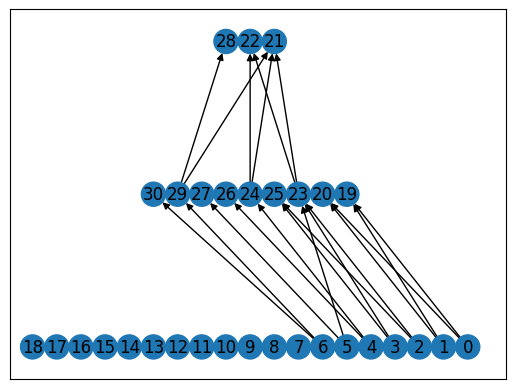

In [3]:
ped_txt = """\
# id parent0 parent1 time is_sample
0	19	20	0.0	1
1	19	20	0.0	1
2	23	25	0.0	1
3	23	25	0.0	1
4	24	26	0.0	1
5	23	27	0.0	1
6	29	30	0.0	1
7	.	.	0.0	1
8	.	.	0.0	1
9	.	.	0.0	1
10	.	.	0.0	1
11	.	.	0.0	1
12	.	.	0.0	1
13	.	.	0.0	1
14	.	.	0.0	1
15	.	.	0.0	1
16	.	.	0.0	1
17	.	.	0.0	1
18	.	.	0.0	1
19	.	.	1.0	0
20	.	.	1.0	0
21	.	.	2.0	0
22	.	.	2.0	0
23	21	22	1.0	0
24	21	22	1.0	0
25	.	.	1.0	0
26	.	.	1.0	0
27	.	.	1.0	0
28	.	.	2.0	0
29	21	28	1.0	0
30	.	.	1.0	0
"""
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=sequence_length)
draw_pedigree(pedigree.tree_sequence())


In [4]:
ts0 = msprime.sim_ancestry(initial_state=pedigree, model="fixed_pedigree", random_seed=1,
                           recombination_rate=0.5/sequence_length)

print(ts0.first().draw_text())
ts0

           43       4544                                                                                
          ┏━┻━━┓     ┃ ┃                                                                                
39413840 46    ┃ 50  ┃ ┃52 55 60                                                                        
┃  ┃ ┃ ┃ ┏┻━┓  ┃ ┏┻┓ ┃ ┃ ┃  ┃  ┃                                                                        
0  1 2 3 4 10 12 5 7 6 8 9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37



In [5]:
ts = msprime.sim_ancestry(population_size=10000,
                         initial_state=ts0,
                        model=[
                                msprime.DiscreteTimeWrightFisher(duration=20),
                                msprime.StandardCoalescent()
                         ],
                         random_seed=1,
                         recombination_rate=scaled_recomb_rate)
ts


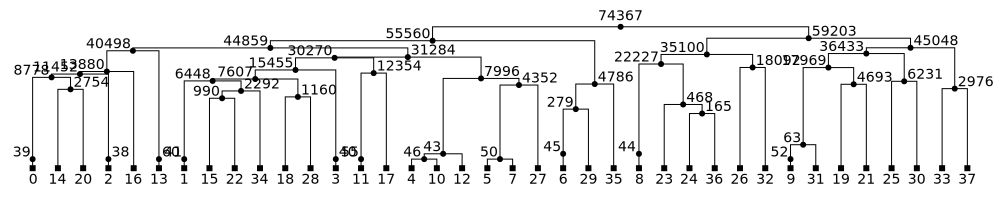

In [6]:
ts.first().draw_svg(size=(1000,200), time_scale='log_time')

## Add metadata

To match the GEL data with pedigrees, let's add metadata for the biological relationship to proband and family id. We'll use this to make better plot legends.

In [147]:
import pandas as pd
metadata_txt = """\
biological_relationship_to_proband	rare_diseases_family_sk	participant_id
Proband	2343	59214
Full Sibling	2343	89262
Proband	3488	32389
Full Sibling	3488	21458
Maternal Cousin Sister	3488	82741
Half Sibling with a shared Mother	3488	48911
Distant Cousin	3488	95071
Proband	1232	38163
Proband	4545	70426
Proband	5754	85393
Proband	2323	37205
Proband	7425	62122
Proband	9124	43256
Proband	3644	14906
Proband	9236	99121
Proband	1277	81038
Proband	1453	80289
Proband	1245	61875
Proband	1345	64324
Mother	2343	64418
Father	2343	94492
Maternal Grandmother	3488	53224
Maternal Grandfather	3488	32477
Mother	3488	20414
Maternal Aunt	3488	27653
Father	3488	58539
Father	3488	18453
Father	3488	13245
Other	3488	13090
Other	3488	29558
Other	3488	49283
"""

metadata = pd.read_csv(io.StringIO(metadata_txt), sep="\t")
metadata

,biological_relationship_to_proband,rare_diseases_family_sk,participant_id
0,Proband,2343,59214
1,Full Sibling,2343,89262
2,Proband,3488,32389
3,Full Sibling,3488,21458
4,Maternal Cousin Sister,3488,82741
5,Half Sibling with a shared Mother,3488,48911
6,Distant Cousin,3488,95071
7,Proband,1232,38163
8,Proband,4545,70426
9,Proband,5754,85393


In [148]:
tables = ts.dump_tables()

for index, table_row in enumerate(tables.individuals):
    tables.individuals[index] = table_row.replace(metadata=metadata.loc[index].to_dict())

ts = tables.tree_sequence()
ts.individual(0)

Individual(id=0, flags=0, location=array([], dtype=float64), parents=array([19, 20], dtype=int32), nodes=array([0, 1], dtype=int32), metadata={'biological_relationship_to_proband': 'Proband', 'participant_id': 59214, 'rare_diseases_family_sk': 2343})

## Make simplified subtree

We want to include the nodes of the proband, full sibling, first cousin, half sibling and an unrelated individual

In [149]:
import numpy as np

ls = []
individuals_sample = [2,3,4,5,15,17,18]
for m in individuals_sample:
    ls.append(ts.individual(m).nodes)
nodes_sample = np.concatenate(ls)
print(nodes_sample)
ts_small, nodes_map = ts.simplify(nodes_sample, map_nodes=True)
ts_small

[ 4  5  6  7  8  9 10 11 30 31 34 35 36 37]


In [150]:
for ind in ts_small.individuals():
    print(ind)

Individual(id=0, flags=0, location=array([], dtype=float64), parents=array([7, 8], dtype=int32), nodes=array([0, 1], dtype=int32), metadata={'biological_relationship_to_proband': 'Proband', 'participant_id': 32389, 'rare_diseases_family_sk': 3488})
Individual(id=1, flags=0, location=array([], dtype=float64), parents=array([7, 8], dtype=int32), nodes=array([2, 3], dtype=int32), metadata={'biological_relationship_to_proband': 'Full Sibling', 'participant_id': 21458, 'rare_diseases_family_sk': 3488})
Individual(id=2, flags=0, location=array([], dtype=float64), parents=array([-1, -1], dtype=int32), nodes=array([4, 5], dtype=int32), metadata={'biological_relationship_to_proband': 'Maternal Cousin Sister', 'participant_id': 82741, 'rare_diseases_family_sk': 3488})
Individual(id=3, flags=0, location=array([], dtype=float64), parents=array([ 7, -1], dtype=int32), nodes=array([6, 7], dtype=int32), metadata={'biological_relationship_to_proband': 'Half Sibling with a shared Mother', 'participant_

## Plot closest neighbours

### Making the dataframe

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns

def shorten_relationship_type(str):
    ### Given a biological_relationship_to_proband string, return a shortened version
    ### for cousins and half siblings

    # if string contains 'half sibling with a shared'
    if 'half sibling with a shared' in str.lower():
        return 'Half Sibling'
    if 'aternal cousin' in str.lower():
        return 'First Cousin'
    else:
        return str

def map_simplified_tree_nodes(nodes_array, nodes_map):
    ### The nth value of nodes_map is the node id of the nth node in the original tree sequence
    ### in the simplified tree sequence. If this node doesn't exist in the simplified ts, the value
    ### is -1. This function inverts nodes_map: given an np.array of node id's in the simplified ts, it returns
    ### an np.array of node id's in the original ts.

    nodes_map_inv = np.zeros(len(nodes_map), dtype=int)
    nodes_map_inv[nodes_map] = np.arange(len(nodes_map))
    return nodes_map_inv[nodes_array]    

def make_span_df(ts, n_per_sample, metadata_cols=['participant_id', 'biological_relationship_to_proband', 
                                       'rare_diseases_family_sk']):
    ### Given a tree sequence, determine an n x n array in which the (i,j)th entry is the 
    ### span of the genome in which the ith and jth samples are siblings in a subtree. 
    ### Melt the dataframe and add on metadata given by the metadata cols.

    sample_span = np.zeros((ts.num_samples, ts.num_samples))

    for tree in ts.simplify().trees(sample_lists=False):
        #print(f"Visiting tree {tree.index}")
        if tree.has_single_root:
            for u in ts.samples():
                #print(f"  Checking neighbours for sample {u} under parent {tree.parent(u)}")
                for nearest in tree.samples(tree.parent(u)):
                    if nearest != u:
                        #print(f"    {nearest} is a neighbour of {u}")
                        #print(f"    Adding {tree.span} to the sample span between {u} and {nearest}")
                        sample_span[u, nearest] += tree.span
    sample_span = sample_span / ts.sequence_length
    samples = [str(s) for s in ts.samples()]
    
    #Construct the dataframe
    span_df = pd.DataFrame(sample_span.T, columns = samples)
    span_df['sample'] = samples
    
    #Melt the dataframe for plotting
    span_melted = span_df.melt(id_vars=['sample'])
    span_melted.set_index('sample',drop=True, inplace=True)
    df = span_melted.groupby('variable')['value'].nlargest(n_per_sample).reset_index()
    df.columns = ['Sample','Neighbour','Value']

    #For each sample node in ts_small, extract the corresponding biological_relationship_to_proband
    #and rare_diseases_family_sk metadata from the associated individual and store it in a dataframe
    #with the node id as the index
    node_metadata = pd.DataFrame(index=ts.samples().astype(int), columns=metadata_cols)
    for node_id in ts.samples():
        ind_id = ts.node(node_id).individual
        ind_metadata = ts.individual(ind_id).metadata
        node_metadata.loc[node_id] = pd.Series({k: v for k, v in ind_metadata.items() if k in metadata_cols})

    #Apply shorten metadata function over biological_relationship_to_proband column
    node_metadata['biological_relationship_to_proband'] = node_metadata['biological_relationship_to_proband'].apply(shorten_relationship_type) 

    # get the unique values in the rare_diseases_family_sk column
    unique_values = node_metadata['rare_diseases_family_sk'].unique()
    # create a dictionary that maps each unique value to its corresponding "Family n" string
    family_dict = {value: f"Family {i+1}" for i, value in enumerate(unique_values)}
    # replace the values in the rare_diseases_family_sk column using the dictionary
    node_metadata['Family'] = node_metadata['rare_diseases_family_sk'].map(family_dict)
    
    #Left join topn with node_metadata on Sample
    df['Sample'] = df['Sample'].astype(int)
    df = df.merge(node_metadata, how='left', left_on='Sample', right_index=True)

    df['Sample'] = df['Sample'].astype(str)
    df['Neighbour'] = df['Neighbour'].astype(str)
    df['participant_id'] = df['participant_id'].astype(str)
    df.sort_values(by='Sample', inplace=True, key=lambda x : x.astype(int))

    return df


### Span plot

In [158]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import rgb2hex

def get_colors(n, colormap):
    ### Return a list of n hex colors from a given matplotlib colormap
    ### (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
    
    cmap = ListedColormap(plt.get_cmap(colormap).colors)
    colors = cmap.colors[:n]
    hex_colors = [rgb2hex(color) for color in colors]
    
    return hex_colors

def format_node_label(node_id, df):
    ### Given a dataframe of nodes and metadata and a node id
    ### Return a formatted string for the node label

    # Get the first row of the dataframe where the Sample is node_id

    row = df[df['Sample'] == node_id].drop_duplicates(subset=['Sample'], keep='first')   
    family_id = row['Family'].iloc[0]
    bio_rel = row['biological_relationship_to_proband'].iloc[0]
    # Return the formatted string
    return f"Node {node_id} - {family_id}'s {bio_rel}"

def get_id_of_sample(sample, df):
    ### Return the participant_id of a given sample from a given dataframe (df).
    return df.loc[df['Sample'] == str(sample), 'participant_id'].values[0]

def plot_x_axis_labels(column_name, bracket_height, df, ax, participantQ, arrow_style, palette='tab20'):
    ### Plot x-axis labels for a given column_name with lines/brackets at a given height
    ### (bracket_height) on a given axis (ax) with style (arrow_style).
    ### The labels are taken from the given dataframe (df).
    ### If participantQ is True, the labels are the relationship_to_proband values, otherwise they are
    ### the values of the given column_name.

    # if participantQ is True, we need to get a color palette for the participant labels
    if participantQ:
        # get colors for all samples from palette
        colors = get_colors(len(df['Sample'].unique()), palette)
        # get every other color from list starting with 0
        colors = colors[::2]

    # get the unique values for the given column_name
    values = df[column_name].unique()
    # loop over the unique values
    for i, value in enumerate(values):
        # get the Samples belonging to the current value
        samples = df.loc[df[column_name] == value, 'Sample'].values
        # get the minimum and maximum x-axis values for the current value
        x_min, x_max = ax.get_xlim()
        x_values = [i for i, sample in enumerate(ax.get_xticks()) if str(sample) in samples]
        x_min = min(x_values)-0.5
        x_max = max(x_values)+0.5

            
        # add the value annotation
        x_pos = x_min + (x_max - x_min) / 2
        if participantQ:
            # get the relationship_to_proband value for the participant
            relationship = df.loc[df['participant_id'] == value, 'biological_relationship_to_proband'].values[0]
            ax.annotate(relationship, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                            annotation_clip=False, color=colors[i])
            # draw the bracket
            ax.annotate('', xytext=(x_min, bracket_height), xy=(x_max, bracket_height),
                        arrowprops=dict(arrowstyle=arrow_style, color=colors[i]), annotation_clip=False)
        else:
            ax.annotate(value, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                            annotation_clip=False)
            # draw the bracket
            ax.annotate('', xytext=(x_min, bracket_height), xy=(x_max, bracket_height),
                        arrowprops=dict(arrowstyle=arrow_style, color='black'), annotation_clip=False)

def plot_span_df(df, ts, palette = 'tab20', normaliseQ = False, fig_width=10):
    ### Plot a span dataframe (df) with a given tree sequence (ts) and color palette (palette).
    ### If normaliseQ is True, the span values are normalised such that the bars are of equal height.

    #neighbours_list ordered for plotting
    neighbours = df['Neighbour'].drop_duplicates().to_list()
    neighbours.sort(key = int)
    
    #using histplot because it can create stacked bar charts nicely
    if normaliseQ:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Norm_Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)
    else:
        ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Value',
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette=palette)

    #neighbours_list ordered for plotting
    neighbours = df['Neighbour'].drop_duplicates().to_list()
    neighbours.sort(key = int)
    #apply format_node_label to each element of the neighbours list and column
    neighbours = [format_node_label(x, df) for x in neighbours]
    df['Neighbour'] = df['Neighbour'].apply(lambda x: format_node_label(x, df))
        
    #using histplot because it can create stacked bar charts nicely
    ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Value', bins=10,
                        multiple='stack', shrink=0.8, hue_order = neighbours, palette='tab20')
    ax.set(xlabel=None, ylabel='Span')
    #add labels two layers of x axis labels
    plot_x_axis_labels(column_name='participant_id', bracket_height=-0.12, df=df, ax=ax, participantQ=True,
                    arrow_style='-', palette=palette)

    plot_x_axis_labels(column_name='Family', bracket_height=-0.25, df=df, ax=ax,
                        participantQ=False, arrow_style='|-|')

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # Set figure size to 20 x 10
    plt.rcParams['figure.figsize'] = [fig_width, fig_width/1.618]
    plt.show()

def plot_span_ts(ts, n_per_sample=3, palette='tab20', normaliseQ=False, fig_width=10):
    ### Plot a span dataframe (df) with a given tree sequence (ts) and color palette (palette).
    df = make_span_df(ts, n_per_sample)
    plot_span_df(df, ts, palette, normaliseQ, fig_width)


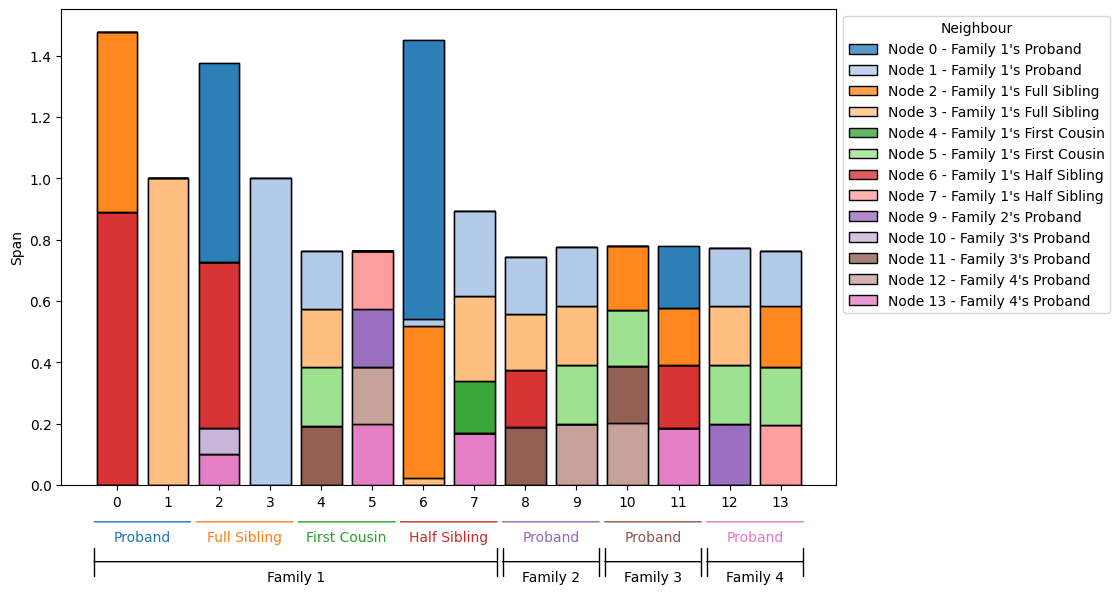

In [160]:
plot_span_ts(ts_small, n_per_sample=4, fig_width=15)

# Scratchpad

In [113]:
metadata_cols = ['participant_id', 'biological_relationship_to_proband', 
                                       'rare_diseases_family_sk']

#For each sample node in ts_small, extract the corresponding biological_relationship_to_proband
#and rare_diseases_family_sk metadata from the associated individual and store it in a dataframe
#with the node id as the index
node_metadata = pd.DataFrame(index=ts_small.samples().astype(int),
                              columns=metadata_cols)
for node_id in ts_small.samples():
    ind_id = ts_small.node(node_id).individual
    ind_metadata = ts_small.individual(ind_id).metadata
    node_metadata.loc[node_id] = pd.Series({k: v for k, v in ind_metadata.items() if k in metadata_cols})

#Apply shorten metadata function over biological_relationship_to_proband column
node_metadata['biological_relationship_to_proband'] = node_metadata['biological_relationship_to_proband'].apply(shorten_relationship_type) 

# get the unique values in the rare_diseases_family_sk column
unique_values = node_metadata['rare_diseases_family_sk'].unique()
# create a dictionary that maps each unique value to its corresponding "Family n" string
family_dict = {value: f"Family {i+1}" for i, value in enumerate(unique_values)}
# replace the values in the rare_diseases_family_sk column using the dictionary
node_metadata['rare_diseases_family_sk'] = node_metadata['rare_diseases_family_sk'].map(family_dict)
   
#Left join topn with node_metadata on Sample
print(topn)
df = topn.merge(node_metadata, how='left', left_on='Sample', right_index=True)
df['Sample'] = df['Sample'].astype(str)
df['Neighbour'] = df['Neighbour'].astype(str)
df['participant_id'] = df['participant_id'].astype(str)


    Sample  Neighbour     Value  Norm_Value
0        0          6  0.890590    0.602420
1        0          2  0.587764    0.397580
2        0          0  0.000000    0.000000
3        1          3  1.000000    1.000000
4        1          0  0.000000    0.000000
5        1          1  0.000000    0.000000
6        2          0  0.697450    0.497508
7        2          6  0.588040    0.419464
8        2          4  0.116396    0.083028
9        3          1  1.000000    1.000000
10       3          0  0.000000    0.000000
11       3          2  0.000000    0.000000
13       4          7  0.275336    0.331989
14       4          1  0.274470    0.330945
12       4          5  0.279547    0.337066
15       5          4  0.284269    0.334972
16       5          9  0.282361    0.332723
17       5          7  0.282006    0.332305
18       6          0  0.919044    0.630113
19       6          2  0.506809    0.347477
20       6          1  0.032685    0.022410
21       7          1  0.351135 

['0', '1', '2', '3', '4', '5', '6', '7', '9']


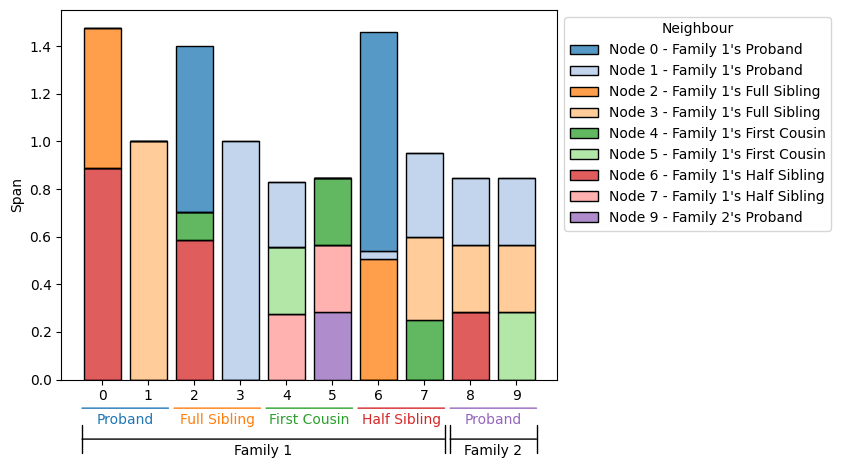

In [100]:
palette = 'tab20'
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import rgb2hex

def get_colors(n, colormap):
    ### Return a list of n hex colors from a given matplotlib colormap
    ### (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
    
    cmap = ListedColormap(plt.get_cmap(colormap).colors)
    colors = cmap.colors[:n]
    hex_colors = [rgb2hex(color) for color in colors]
    
    return hex_colors

def get_id_of_sample(sample, df):
    ### Return the participant_id of a given sample from a given dataframe (df).
    return df.loc[df['Sample'] == str(sample), 'participant_id'].values[0]

def plot_x_axis_labels(column_name, bracket_height, df, ax, participantQ, arrow_style, palette='tab20'):
    ### Plot x-axis labels for a given column_name with lines/brackets at a given height
    ### (bracket_height) on a given axis (ax) with style (arrow_style).
    ### The labels are taken from the given dataframe (df).
    ### If participantQ is True, the labels are the relationship_to_proband values, otherwise they are
    ### the values of the given column_name.

    # if participantQ is True, we need to get a color palette for the participant labels
    if participantQ:
        # get colors for all samples from palette
        colors = get_colors(len(df['Sample'].unique()), palette)
        # get every other color from list starting with 0
        colors = colors[::2]

    # get the unique values for the given column_name
    values = df[column_name].unique()
    # loop over the unique values
    for i, value in enumerate(values):
        # get the Samples belonging to the current value
        samples = df.loc[df[column_name] == value, 'Sample'].values
        # get the minimum and maximum x-axis values for the current value
        x_min, x_max = ax.get_xlim()
        x_values = [i for i, sample in enumerate(ax.get_xticks()) if str(sample) in samples]
        x_min = min(x_values)-0.5
        x_max = max(x_values)+0.5

            
        # add the value annotation
        x_pos = x_min + (x_max - x_min) / 2
        if participantQ:
            # get the relationship_to_proband value for the participant
            relationship = df.loc[df['participant_id'] == value, 'biological_relationship_to_proband'].values[0]
            ax.annotate(relationship, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                            annotation_clip=False, color=colors[i])
            # draw the bracket
            ax.annotate('', xytext=(x_min, bracket_height), xy=(x_max, bracket_height),
                        arrowprops=dict(arrowstyle=arrow_style, color=colors[i]), annotation_clip=False)
        else:
            ax.annotate(value, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                            annotation_clip=False)
            # draw the bracket
            ax.annotate('', xytext=(x_min, bracket_height), xy=(x_max, bracket_height),
                        arrowprops=dict(arrowstyle=arrow_style, color='black'), annotation_clip=False)


#neighbours_list ordered for plotting
neighbours = df['Neighbour'].drop_duplicates().to_list()
neighbours.sort(key = int)
#apply format_node_label to each element of neighbours
print(neighbours)
neighbours = [format_node_label(x, df) for x in neighbours]
df['Neighbour'] = df['Neighbour'].apply(lambda x: format_node_label(x, df))
    
#using histplot because it can create stacked bar charts nicely
ax = sns.histplot(df, x='Sample', hue='Neighbour', weights='Value', bins=10,
                      multiple='stack', shrink=0.8, hue_order = neighbours, palette='tab20')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel=None, ylabel='Span')
plot_x_axis_labels(column_name='participant_id', bracket_height=-0.12, df=df, ax=ax, participantQ=True,
                   arrow_style='-', palette=palette)

plot_x_axis_labels(column_name='rare_diseases_family_sk', bracket_height=-0.25, df=df, ax=ax,
                    participantQ=False, arrow_style='|-|')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
# get the unique Family values
families = df['rare_diseases_family_sk'].unique()
# set the height of the curly bracket
bracket_height = -0.25
# loop over the unique Family values
for family in families:
    # get the Samples belonging to the current Family
    family_samples = df.loc[df['rare_diseases_family_sk'] == family, 'Sample'].values
    # get the minimum and maximum x-axis values for the current Family
    x_min, x_max = ax.get_xlim()
    family_x_values = [i for i, sample in enumerate(ax.get_xticks()) if str(sample) in family_samples]
    family_x_min = min(family_x_values)-0.5
    family_x_max = max(family_x_values)+0.5
    # draw the curly bracket
    ax.annotate('', xytext=(family_x_min, bracket_height), xy=(family_x_max, bracket_height),
                    arrowprops=dict(arrowstyle='|-|', color='black'), annotation_clip=False)
        
    # add the Family annotation
    x_pos = family_x_min + (family_x_max - family_x_min) / 2
    ax.annotate(family, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                    annotation_clip=False)
    
# get the unique participant ids
participants = df['participant_id'].unique()

# set the height of the curly bracket
bracket_height = -0.12
# loop over the participants
for i, id in enumerate(participants):
    # get the Samples belonging to the current participant
    samples = df.loc[df['participant_id'] == id, 'Sample'].values
    # get the relationship_to_proband value for the participant
    relationship = df.loc[df['participant_id'] == id, 'biological_relationship_to_proband'].values[0]
    # get the minimum and maximum x-axis values for the current participant
    x_min, x_max = ax.get_xlim()
    x_values = [i for i, sample in enumerate(ax.get_xticks()) if get_id_of_sample(sample, df) == id]
    x_min = min(x_values)-0.5
    x_max = max(x_values)+0.5
    # draw the curly bracket
    ax.annotate('', xytext=(x_min, bracket_height), xy=(x_max, bracket_height),
                    arrowprops=dict(arrowstyle='-', color=colors[i]), annotation_clip=False)
        
    # add the relationship_to_proband annotation
    x_pos = x_min + (x_max - x_min) / 2
    ax.annotate(relationship, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                    annotation_clip=False, color=colors[i])

In [ ]:

    # get the unique Family values
    families = df['rare_diseases_family_sk'].unique()

    # set the height of the curly bracket
    bracket_height = -0.15

    # loop over the unique Family values
    for family in families:
        # get the Samples belonging to the current Family
        family_samples = df.loc[df['rare_diseases_family_sk'] == family, 'Sample'].values
        # get the minimum and maximum x-axis values for the current Family
        x_min, x_max = ax.get_xlim()
        family_x_values = [i for i, sample in enumerate(ax.get_xticks()) if str(sample) in family_samples]
        family_x_min = min(family_x_values)-0.5
        family_x_max = max(family_x_values)+0.5
        print(family_x_values)
        # draw the curly bracket
        ax.annotate('', xytext=(family_x_min, bracket_height), xy=(family_x_max, bracket_height),
                    arrowprops=dict(arrowstyle='|-|', color='black'), annotation_clip=False)
        
        # add the Family annotation
        x_pos = family_x_min + (family_x_max - family_x_min) / 2
        ax.annotate(family, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                    annotation_clip=False)


def annotate_x_axis(variable, df, ax, bracket_height):
    ### Function to annotate the x-axis of a seaborn plot with curly brackets and text
    
    # get the unique values in the variable column
    values = df[variable].unique()
    # loop over the unique values
    for value in values:
        # get the Samples belonging to the current value
        value_samples = df.loc[df[variable] == value, 'Sample'].values
        # get the minimum and maximum x-axis values for the current value
        x_min, x_max = ax.get_xlim()
        value_x_values = [i for i, sample in enumerate(ax.get_xticks()) if str(sample) in value_samples]
        value_x_min = min(value_x_values)-0.5
        value_x_max = max(value_x_values)+0.5
        # draw the curly bracket
        ax.annotate('', xytext=(value_x_min, bracket_height), xy=(value_x_max, bracket_height),
                    arrowprops=dict(arrowstyle='|-|', color='black'), annotation_clip=False)
        # add the value annotation
        x_pos = value_x_min + (value_x_max - value_x_min) / 2
        ax.annotate(value, xy=(x_pos, bracket_height - 0.05), ha='center', va='center',
                    annotation_clip=False)